<a href="https://colab.research.google.com/github/RegmiYogesh/Gee_digitization/blob/main/Final_code_for_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import gdal
import keras
import tensorflow as tf
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure
from google.colab import drive
import tensorflow as tf

from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Activation, BatchNormalization, Reshape
from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adadelta

import tensorflow.python.keras.backend as K
sess = K.get_session()
from tensorflow.compat.v1.keras.backend import set_session
from keras.layers import LeakyReLU
import pickle
import matplotlib.pyplot as plt 
import sys

Populating the interactive namespace from numpy and matplotlib


In [ ]:
os.getcwd()

'/content'

In [ ]:
IMAGE_PATH='/content/drive/MyDrive/ML'
LABEL_PATH='/content/drive/MyDrive/Label'

In [ ]:
#Create list of the VHR images 
image_list={}
for f in sorted(os.listdir(IMAGE_PATH)):
    fdir = os.path.join(IMAGE_PATH, f)
    _, ext = os.path.splitext(f)
    if ext.lower() == ".tif":
        imgtype = f[-9:-4]
        image_data=gdal.Open(fdir)
        bands = [image_data.GetRasterBand(i+1).ReadAsArray() for i in range(image_data.RasterCount)]
        image_list[imgtype] = np.stack(bands, axis=2)

In [ ]:
label_list={}
for f in sorted(os.listdir(LABEL_PATH)):
    fdir = os.path.join(LABEL_PATH, f)
    _, ext = os.path.splitext(f)
    if ext.lower() == ".tif":
        imgtype = f[-9:-4]
        label_data=gdal.Open(fdir)
        bands = [label_data.GetRasterBand(i+1).ReadAsArray() for i in range(label_data.RasterCount)]
        label_list[imgtype] = np.stack(bands, axis=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


[0 1]


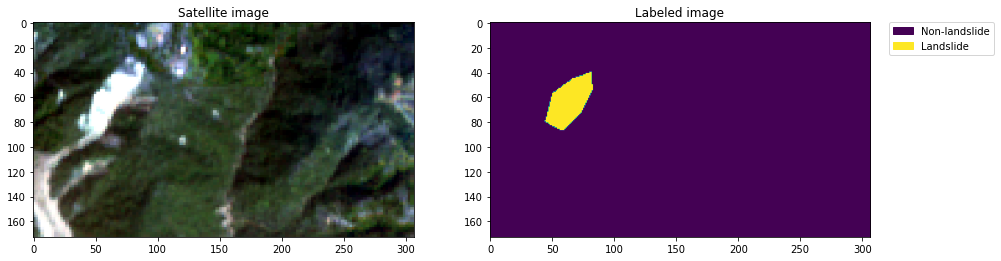

In [ ]:
sample_image="01"
sample_label="01"

def visualize_data(data,data2):
    f, axarr = plt.subplots(1,2)
    data = data[:, :, 0:3]
    _ = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = _
    data = data.astype(np.float)
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    axarr[0].imshow(data)
    axarr[0].set_title("Satellite image")

    a=axarr[1]
    values = np.unique(data2.ravel())
    im = axarr[1].imshow(data2[:,:,0])
    a.set_title("Labeled image")
    colors = [im.cmap(im.norm(value)) for value in values] 
    data2 = ["Non-landslide", "Landslide"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), data2)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

visualize_data(image_list[sample_image],label_list[sample_label])

In [ ]:
image_list.keys()

dict_keys(['01', '02'])

['01', '02']

In [26]:
PATCHSIZE = 128
NBANDS = image_list["01"].shape[-1]

def gridwise_sample(imgarray, patchsize):
    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner.
    """
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape=(0, patchsize, patchsize, nbands),
                            dtype=imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize, :]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

Xtrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Ytrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.uint8)
# sample each training tile systematically in a gridwise manner
# train_areas = list(image_list.keys())
train_areas=['01']
for area in train_areas:
    X_toadd = gridwise_sample(image_list[area], PATCHSIZE)
    Y_toadd = gridwise_sample(label_list[area], PATCHSIZE)
    Xtrain = np.concatenate((Xtrain, X_toadd), axis=0)
    Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)
# encode all non-landslide classes as one class
# Ytrain[Ytrain!=2] = 1
print("There are %i number of training patches" % (Xtrain.shape[0]))

There are 2 number of training patches


In [29]:
     #Check the percentage of landslide pixels with respect to non-landslides
ls_px=len(Ytrain[Ytrain==1])/(len(Ytrain[Ytrain==0])+len(Ytrain[Ytrain==1]))
nonls_px=len(Ytrain[Ytrain==0])/(len(Ytrain[Ytrain==1])+len(Ytrain[Ytrain==0]))
print("Pixel percentage of landslides = " + str(ls_px* 100)) #We can observe that the percentage of landslide pixels are really less (<10%)
print("Pixel percentage of non-landslides = " + str(nonls_px* 100)) 

Pixel percentage of landslides = 3.2073974609375
Pixel percentage of non-landslides = 96.7926025390625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


[0 1]


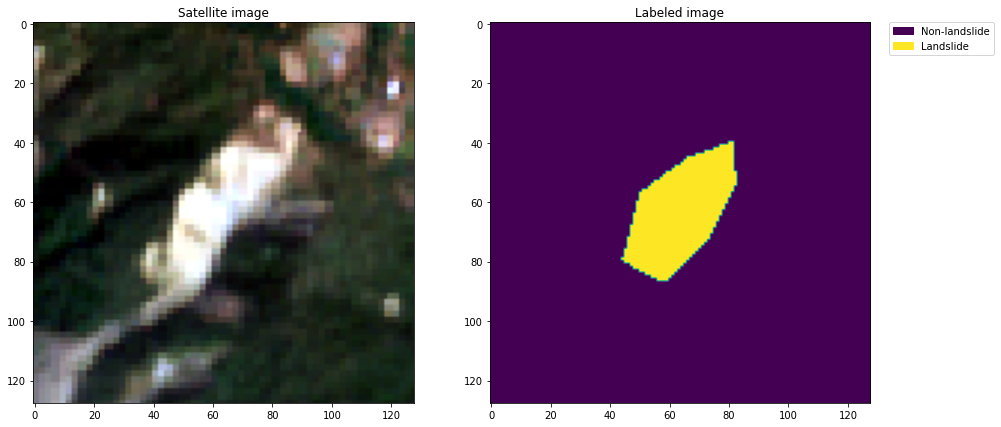

In [28]:
#Visualize the Patches of Image
PATCH_NO = 0
visualize_data(Xtrain[PATCH_NO],Ytrain[PATCH_NO])

In [ ]:
def to_categorical_4d(y, nc):
    Y = np.zeros((y.shape[0],
                  y.shape[1],
                  y.shape[2],
                  nc),
                  dtype=np.int32)
    for h in range(y.shape[0]):
        for i in range(y.shape[1]):
            for j in range(y.shape[2]):
                if y[h, i, j, 0] != 0:
                    Y[h, i, j, y[h, i, j, 0]-1] = 1
                else:
                    continue
    return Y
# transform target arrays to one-hot encodings
Ytrain = to_categorical_4d(Ytrain, 2)

In [ ]:
#Model builder
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.compat.v1.Session(config=config))

NUMBER_BANDS = 3
NUMBER_CLASSES = 2
NUMBER_EPOCHS = 300  
nclasses=2
def build_FCN(optimizer, nrows, ncols, nbands,nclasses):
    model = keras.models.Sequential()
    model.add(ZeroPadding2D((2, 2), input_shape=(nrows, ncols, nbands)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((2, 2)))
    model.add(MaxPooling2D(
              pool_size=(5, 5),
              strides=(1, 1)
    ))
    model.add(ZeroPadding2D((4, 4)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(2, 2)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((4, 4)))
    model.add(MaxPooling2D(
            pool_size=(9, 9),
            strides=(1, 1)
    ))
    model.add(ZeroPadding2D((6, 6)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(3, 3)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((6, 6)))
    model.add(MaxPooling2D(
            pool_size=(13, 13),
            strides=(1, 1)
    ))
    model.add(Convolution2D(
              filters=nclasses,
              kernel_size=(1, 1)
    ))
    model.add(keras.layers.Activation(
              activation="softmax"
    ))
    model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)
    return model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
fcn = build_FCN(opt, PATCHSIZE, PATCHSIZE, NUMBER_BANDS,NUMBER_CLASSES)

fcn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m]) # Use of'adam' optimiser

In [ ]:
def train(model, data, labels):
    hist = model.fit(x=data,
                     y=labels,
                     epochs=20,
                     verbose=2
                    )
    return hist

history = train(fcn, Xtrain, Ytrain)

Epoch 1/20
1/1 - 5s - loss: 0.3032 - acc: 0.9800 - f1_m: 0.9800 - precision_m: 0.9800 - recall_m: 0.9800 - 5s/epoch - 5s/step
Epoch 2/20
1/1 - 5s - loss: 0.2627 - acc: 0.9952 - f1_m: 0.9952 - precision_m: 0.9952 - recall_m: 0.9952 - 5s/epoch - 5s/step
Epoch 3/20
1/1 - 5s - loss: 0.2373 - acc: 0.9994 - f1_m: 0.9994 - precision_m: 0.9994 - recall_m: 0.9994 - 5s/epoch - 5s/step
Epoch 4/20
1/1 - 5s - loss: 0.2014 - acc: 0.9994 - f1_m: 0.9994 - precision_m: 0.9994 - recall_m: 0.9994 - 5s/epoch - 5s/step
Epoch 5/20
1/1 - 5s - loss: 0.1756 - acc: 0.9988 - f1_m: 0.9988 - precision_m: 0.9988 - recall_m: 0.9988 - 5s/epoch - 5s/step
Epoch 6/20
1/1 - 5s - loss: 0.1639 - acc: 0.9994 - f1_m: 0.9994 - precision_m: 0.9994 - recall_m: 0.9994 - 5s/epoch - 5s/step
Epoch 7/20
1/1 - 5s - loss: 0.1478 - acc: 0.9995 - f1_m: 0.9995 - precision_m: 0.9995 - recall_m: 0.9995 - 5s/epoch - 5s/step
Epoch 8/20
1/1 - 5s - loss: 0.1317 - acc: 0.9998 - f1_m: 0.9998 - precision_m: 0.9998 - recall_m: 0.9998 - 5s/epoch - 

In [ ]:
hist

<function matplotlib.pyplot.hist>

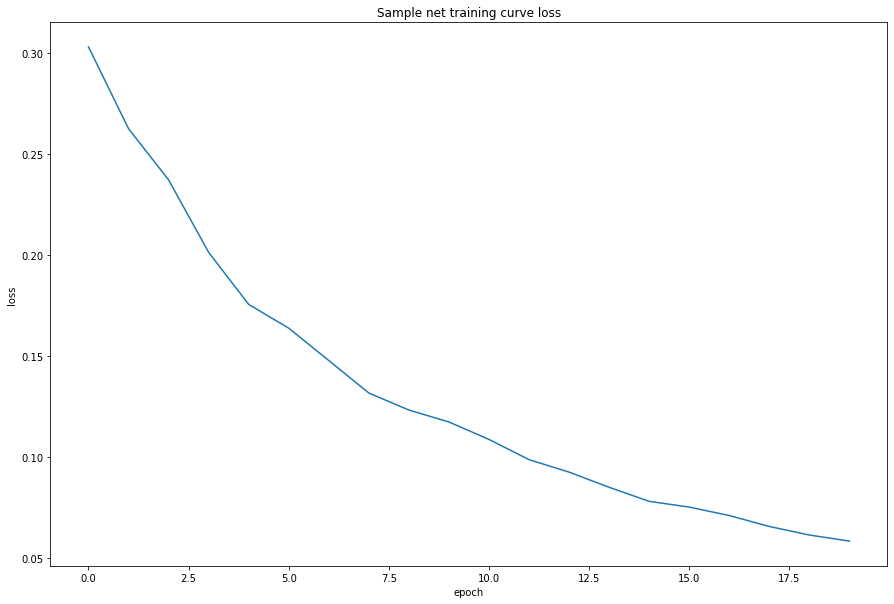

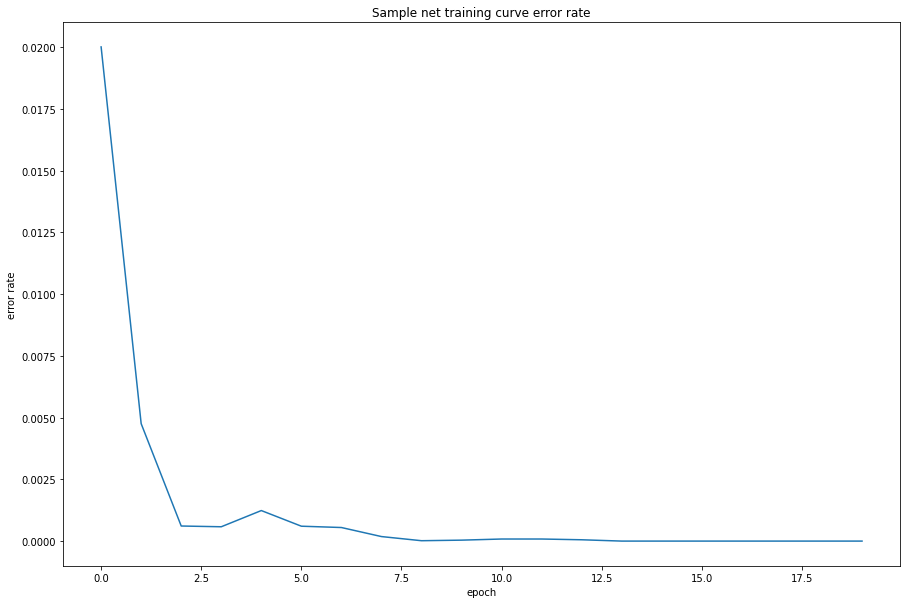

In [ ]:
plt.plot(history.history["loss"])
plt.title("Sample net training curve loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
plt.plot(1-np.array(history.history["acc"]))
plt.title("Sample net training curve error rate")
plt.ylabel("error rate")
plt.xlabel("epoch")
plt.show()

In [ ]:
import imp, h5py
imp.reload(h5py)
model_fname = "/content/drive/MyDrive/Colab Notebooks/model_saved"
fcn.save(model_fname)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/model_saved/assets


In [ ]:
Xtest=Xtrain[1]
Ytest=Ytrain[1]
cut = 128
overlap = 96

(128, 128, 2)